In [2]:
import intake
import allel
import numpy as np
import matplotlib.pyplot as plt
from dask_kubernetes import KubeCluster
from dask.distributed import Client
import pandas as pd
%matplotlib inline

import dask.array as da

import seaborn as sns
sns.set_context('paper')

import scipy.stats as ss

import functools
import zarr

import fsspec
import random

import yaml

import dask

import gcsfs
from pathlib import Path

## Setup

In [3]:
cluster = KubeCluster(n_workers=20)
client = Client(cluster)

client

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tcp://10.33.122.206:40795
distributed.scheduler - INFO -   dashboard at:                     :8787
distributed.scheduler - INFO - Receive client connection: Client-281893d8-6ae5-11eb-8073-b6c1e47fabd0
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.33.122.206:40795 Dashboard: /user/jonbrenas1/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
# Use `cache_timeout=0` to prevent object list cache, to avoid recreating map for Zarr consolidated metadata
gcs_orig = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)
gcs =  gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token=gcs_orig.session.credentials, cache_timeout=0)


In [5]:
cat = intake.open_catalog('https://malariagen.github.io/intake/gcs.yml')
cat

gcs:
  args:
    path: https://malariagen.github.io/intake/gcs.yml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    version: 1


In [6]:
ag3 = cat.ag3
ag3

ag3:
  args:
    path: https://malariagen.github.io/intake/gcs/ag3.yml
  description: 'The MalariaGEN Anopheles gambiae 1000 Genomes Project phase 3 data
    resource. These data are published by the Anopheles gambiae 1000 Genomes Consortium.
    Please note that data included in these catalogs are made available prior to publication
    and subject to the Ag1000G terms of use - https://www.malariagen.net/data/terms-use/ag1000g-terms-use.

    '
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    catalog_dir: https://malariagen.github.io/intake


In [7]:
df_sets = ag3.sample_sets.read()
df_sets

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
distributed.scheduler - INFO - Register tcp://10.33.213.3:33589
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.213.3:33589
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.119.104:37877
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.119.104:37877
distributed.core - INFO - Starting established connection


,sample_set,sample_count
0,AG1000G-AO,81
1,AG1000G-BF-A,181
2,AG1000G-BF-B,102
3,AG1000G-BF-C,13
4,AG1000G-CD,76
5,AG1000G-CF,73
6,AG1000G-CI,80
7,AG1000G-CM-A,303
8,AG1000G-CM-B,97
9,AG1000G-CM-C,44


In [8]:
genome_path_gcs = 'gs://vo_agam_release/reference/genome/agamp4/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.zarr'
genome_store = fsspec.get_mapper(genome_path_gcs)
genome = zarr.open_consolidated(genome_store)
genome

<zarr.hierarchy.Group '/'>

In [9]:
df_all_species = pd.DataFrame()
for s in df_sets['sample_set'][:-1]:
    print(s)
    df_species = cat.ag3.species_calls_20200422_aim(sample_set=s).read()
    df_species['species'] = df_species.species_gambcolu_arabiensis.copy()
    loc_gamb_colu = df_species.species_gambcolu_arabiensis == 'gamb_colu'
    df_species.loc[loc_gamb_colu, 'species'] = df_species.species_gambiae_coluzzii[loc_gamb_colu]
    df_all_species = df_all_species.append(df_species)
    print(df_species.groupby('species').size())

AG1000G-AO
species
coluzzii    81
dtype: int64
AG1000G-BF-A
species
coluzzii        82
gambiae         98
intermediate     1
dtype: int64
AG1000G-BF-B
species
arabiensis     3
coluzzii      53
gambiae       46
dtype: int64
AG1000G-BF-C
species
gambiae    13
dtype: int64
AG1000G-CD
species
gambiae    76
dtype: int64
AG1000G-CF
species
coluzzii    18
gambiae     55
dtype: int64
AG1000G-CI
species
coluzzii    80
dtype: int64
AG1000G-CM-A
species
gambiae    303
dtype: int64
AG1000G-CM-B
species
coluzzii     7
gambiae     90
dtype: int64
AG1000G-CM-C
species
arabiensis     2
coluzzii      19
gambiae       23
dtype: int64
AG1000G-FR
species
gambiae    23
dtype: int64
AG1000G-GA-A
species
gambiae    69
dtype: int64
AG1000G-GH
species
coluzzii    64
gambiae     36
dtype: int64
AG1000G-GM-A
species
coluzzii         5
gambiae         58
intermediate    11
dtype: int64
AG1000G-GM-B
species
coluzzii        16
gambiae          9
intermediate     6
dtype: int64
AG1000G-GM-C
species
coluzzii        1

In [10]:
df_all_species

,sample_id,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,species
0,AR0047-C,0.945,0.001,gamb_colu,coluzzii,coluzzii
1,AR0049-C,0.933,0.001,gamb_colu,coluzzii,coluzzii
2,AR0051-C,0.937,0.002,gamb_colu,coluzzii,coluzzii
3,AR0061-C,0.938,0.002,gamb_colu,coluzzii,coluzzii
4,AR0078-C,0.926,0.001,gamb_colu,coluzzii,coluzzii
...,...,...,...,...,...,...
285,AC0295-C,0.026,0.002,gamb_colu,gambiae,gambiae
286,AC0296-C,0.029,0.003,gamb_colu,gambiae,gambiae
287,AC0297-C,0.026,0.002,gamb_colu,gambiae,gambiae
288,AC0298-C,0.029,0.002,gamb_colu,gambiae,gambiae


In [11]:
chromosomes = ['3R','3L']

In [12]:
# Determine the output cloud directory path
output_cloud_bucket_path = Path("jon_brenas_bucket")
output_cloud_zarr_path = output_cloud_bucket_path / 'Watt-Theta.zarr'
output_zarr_map = gcs.get_mapper(output_cloud_zarr_path.as_posix())
results = zarr.group(output_zarr_map) # Sometimes errors with `overwrite=True`, sometimes errors without, when dir not exist

In [13]:
# Determine the input cloud directory path for non_n-ness
nonn_bucket_path = Path("vo_agam_production")
nonn_cloud_zarr_path = nonn_bucket_path / 'resources' / 'observatory' / 'ag.allsites.nonN.zarr'
nonn_zarr_map = gcs.get_mapper(nonn_cloud_zarr_path.as_posix())
nonn = zarr.group(nonn_zarr_map) # Sometimes errors with `overwrite=True`, sometimes errors without, when dir not exist

In [14]:
# Determine the input cloud directory path for accessibility
accessibility_bucket_path = Path("vo_agam_production")
accessibility_cloud_zarr_path = accessibility_bucket_path / 'resources' / 'observatory' / 'non_n_accessibility' / 'non_n_accessibility.zarr'
accessibility_zarr_map = gcs.get_mapper(accessibility_cloud_zarr_path.as_posix())
accessibility = zarr.group(accessibility_zarr_map) # Sometimes errors with `overwrite=True`, sometimes errors without, when dir not exist

In [15]:
# Determine the input cloud directory path for species masks
gc_pass_bucket_path = Path("vo_agam_release")
gc_pass_cloud_zarr_path = gc_pass_bucket_path / 'v3' / 'site_filters' / 'dt_20200416' / 'gamb_colu'
gc_pass_zarr_map = gcs.get_mapper(gc_pass_cloud_zarr_path.as_posix())
gc_pass = zarr.group(gc_pass_zarr_map) # Sometimes errors with `overwrite=True`, sometimes errors without, when dir not exist

In [16]:
# Determine the in putcloud directory path for annotations
annotations_bucket_path = Path("vo_agam_release")
annotations_cloud_zarr_path = annotations_bucket_path / 'reference' / 'genome' / 'agamp4' / 'Anopheles-gambiae-PEST_SEQANNOTATION_AgamP4.12.zarr'
annotations_zarr_map = gcs.get_mapper(annotations_cloud_zarr_path.as_posix())
annotations = zarr.group(annotations_zarr_map) # Sometimes errors with `overwrite=True`, sometimes errors without, when dir not exist

In [17]:
codon_position_lg = annotations['codon_position']
codon_degeneracy_lg = annotations['codon_degeneracy']
seq_cls_lg = annotations['seq_cls']
seq_flen_lg = annotations['seq_flen']
seq_relpos_start_lg = annotations['seq_relpos_start']
seq_relpos_stop_lg = annotations['seq_relpos_stop']

In [18]:
pos = {}
for ch in chromosomes:
    pos[ch] = nonn[ch]['variants']['POS']

In [19]:
codon_position_da = {}
codon_degeneracy_da = {}
seq_cls_da = {}
seq_flen_da = {}
seq_relpos_start_da = {}
seq_relpos_stop_da = {}
for ch in chromosomes:
    codon_position_da[ch] = da.from_array(codon_position_lg[ch], chunks='auto')
    codon_degeneracy_da[ch] = da.from_array(codon_degeneracy_lg[ch], chunks='auto')
    seq_cls_da[ch] = da.from_array(seq_cls_lg[ch], chunks='auto')
    seq_flen_da[ch] = da.from_array(seq_flen_lg[ch], chunks='auto')
    seq_relpos_start_da[ch] = da.from_array(seq_relpos_start_lg[ch], chunks='auto')
    seq_relpos_stop_da[ch] = da.from_array(seq_relpos_stop_lg[ch], chunks='auto')

In [20]:
codon_position = {}
codon_degeneracy = {}
seq_cls = {}
seq_flen = {}
seq_relpos_start = {}
seq_relpos_stop = {}
for ch in chromosomes:
    codon_position[ch] = codon_position_da[ch][[p-1 for p in pos[ch]]]
    codon_degeneracy[ch] = codon_degeneracy_da[ch][[p-1 for p in pos[ch]]]
    seq_cls[ch] = seq_cls_da[ch][[p-1 for p in pos[ch]]]
    seq_flen[ch] = seq_flen_da[ch][[p-1 for p in pos[ch]]]
    seq_relpos_start[ch] = seq_relpos_start_da[ch][[p-1 for p in pos[ch]]]
    seq_relpos_stop[ch] = seq_relpos_stop_da[ch][[p-1 for p in pos[ch]]]

distributed.scheduler - INFO - Register tcp://10.33.233.2:34959
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.233.2:34959
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.225.2:45363
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.225.2:45363
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.239.2:45973
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.239.2:45973
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.226.2:46069
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.226.2:46069
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.231.2:35565
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.231.2:35565
distributed.c

In [21]:
CLS_UNKNOWN = 0
CLS_UPSTREAM = 1
CLS_DOWNSTREAM = 2
CLS_5UTR = 3
CLS_3UTR = 4
CLS_CDS_FIRST = 5
CLS_CDS_MID = 6
CLS_CDS_LAST = 7
CLS_INTRON_FIRST = 8
CLS_INTRON_MID = 9
CLS_INTRON_LAST = 10

feature_cls_names = [
    'Unknown',
    'Upstream',
    'Downstream',
    "5' UTR",
    "3' UTR",
    "CDS (first)",
    "CDS (mid)",
    "CDS (last)",
    "Intron (first)",
    "Intron (mid)",
    "Intron (last)",
]

In [22]:
DEG_UNKNOWN = 0
DEG_0 = 1
DEG_2_SIMPLE = 2
DEG_2_COMPLEX = 3
DEG_4 = 4

degeneracy_names = [
    'unknown', '0-fold', '2-fold simple', '2-fold complex', 'f-fold'
]

In [23]:
@functools.lru_cache(maxsize=None)
def compute_selections(chrom):
    _is_accessible = accessibility[chrom]['is_accessible'][:]
    _codon_pos = codon_position[chrom][:]
    _codon_deg = codon_degeneracy[chrom][:]
    _seq_cls = seq_cls[chrom][:]
    _seq_flen = seq_flen[chrom][:]
    _seq_relpos_start = seq_relpos_start[chrom][:]
    _seq_relpos_stop = seq_relpos_stop[chrom][:]
    selections = [
        ('First codon position, non-degenerate',
         (_is_accessible &
          (_codon_pos == 0) & 
          (_codon_deg == DEG_0)
         )
        ),
        ('Second codon position, non-degenerate',
         (_is_accessible &
          (_codon_pos == 1) & 
          (_codon_deg == DEG_0)
         )
        ),
        ('Third codon position, 2-fold simple degenerate',
         (_is_accessible &
          (_codon_pos == 2) & 
          (_codon_deg == DEG_2_SIMPLE)
         )
        ),  
        ('Third codon position, 4-fold degenerate',
         (_is_accessible &
          (_codon_pos == 2) & 
          (_codon_deg == DEG_4)
         )
        ),
        ("Intron (\\textless 100bp)",
         (_is_accessible & 
          ((_seq_cls == CLS_INTRON_FIRST) |
           (_seq_cls == CLS_INTRON_MID) |
           (_seq_cls == CLS_INTRON_LAST)) &
          (_seq_flen < 100) & 
          (_seq_relpos_start > 6) & 
          (_seq_relpos_stop > 3)
         )
        ),
        ("Intron (100-200bp)",
         (_is_accessible & 
          ((_seq_cls == CLS_INTRON_FIRST) |
           (_seq_cls == CLS_INTRON_MID) |
           (_seq_cls == CLS_INTRON_LAST)) &
          (_seq_flen >= 100) &
          (_seq_flen < 200) & 
          (_seq_relpos_start > 6) & 
          (_seq_relpos_stop > 3)
         )
        ),
        ("Intron (\\textgreater 200bp)",
         (_is_accessible & 
          ((_seq_cls == CLS_INTRON_FIRST) |
           (_seq_cls == CLS_INTRON_MID) |
           (_seq_cls == CLS_INTRON_LAST)) &
          (_seq_flen > 200) & 
          (_seq_relpos_start > 6) & 
          (_seq_relpos_stop > 3)
         )
        ),
        ("Intron 5' splice site (2bp)",
         (_is_accessible & 
          ((_seq_cls == CLS_INTRON_FIRST) |
           (_seq_cls == CLS_INTRON_MID) |
           (_seq_cls == CLS_INTRON_LAST)) &
          (_seq_relpos_start < 2)
         )
        ),
        ("Intron 3' splice site (2bp)",
         (_is_accessible & 
          ((_seq_cls == CLS_INTRON_FIRST) |
           (_seq_cls == CLS_INTRON_MID) |
           (_seq_cls == CLS_INTRON_LAST)) &
          (_seq_relpos_stop < 2)
         )
        ),
        ("5' UTR",
         (_is_accessible & (_seq_cls == CLS_5UTR))
        ),
        ("3' UTR",
         (_is_accessible & (_seq_cls == CLS_3UTR))
        ),
        ('Upstream (\\textless 1kb from gene)',
         (_is_accessible & 
          (_seq_cls == CLS_UPSTREAM) & 
          (_seq_relpos_stop < 1000)
         )
        ),
        ('Downstream (\\textless 1kb from gene)',
         (_is_accessible & 
          (_seq_cls == CLS_DOWNSTREAM) & 
          (_seq_relpos_start < 1000)
         )
        ),
        ('Intergenic (\\textgreater 10kb from gene)',
         (_is_accessible & 
          (((_seq_cls == CLS_UPSTREAM) & (_seq_relpos_stop > 10000)) | 
           ((_seq_cls == CLS_DOWNSTREAM) & (_seq_relpos_start > 10000)))
         )
        ),
    ]
    #selections = [(k, zarr.array(v)) for k, v in selections]
    sel_dict = {k: v for k, v in selections}
    return sel_dict #selections

In [24]:
sel = {'3R': compute_selections('3R')['Third codon position, 4-fold degenerate'], '3L': compute_selections('3L')['Third codon position, 4-fold degenerate']}

In [25]:
seq_id = '3R'
gt = allel.GenotypeDaskArray(da.concatenate([cat.ag3.snp_genotypes(sample_set=ss).to_zarr()[seq_id]['calldata']['GT'] for ss in list(df_sets['sample_set'][:-1])], axis=1))

## Functions

In [26]:
#@functools.lru_cache(maxsize=None)
def load_mask(seq_id, datasets, max_miss=.1):
#     print('load_mask', seq_id)
    # site filters
    filter_pass = cat.ag3.site_filters_dt_20200416_gamb_colu.to_zarr()[seq_id]['variants']['filter_pass'][:]
    
    # missingness
    gt = allel.GenotypeDaskArray(da.concatenate([cat.ag3.snp_genotypes(sample_set=ds).to_zarr()[seq_id]['calldata']['GT'] for ds in datasets], axis=1))
    n_miss = gt.count_missing(axis=1).compute()
    n_samples = gt.shape[1]
    low_miss = (n_miss / n_samples) < max_miss
    
    # combine
    mask = filter_pass & low_miss & sel[seq_id]
    
    return mask

#@functools.lru_cache(maxsize=None)
def load_mask_arab(seq_id, datasets, max_miss=.1):
#     print('load_mask', seq_id)
    # site filters
    filter_pass = cat.ag3.site_filters_dt_20200416_arab.to_zarr()[seq_id]['variants']['filter_pass'][:]
    
    # missingness
    gt = allel.GenotypeDaskArray(da.concatenate([cat.ag3.snp_genotypes(sample_set=ds).to_zarr()[seq_id]['calldata']['GT'] for ds in datasets], axis=1))
    n_miss = gt.count_missing(axis=1).compute()
    n_samples = gt.shape[1]
    low_miss = (n_miss / n_samples) < max_miss
    
    # combine
    mask = filter_pass & low_miss & sel[seq_id]
    
    return mask

@functools.lru_cache(maxsize=None)
def load_pos(seq_id):
#     print('load_pos', seq_id)
    pos = allel.SortedIndex(cat.ag3.snp_sites.to_zarr()[seq_id]['variants']['POS'])
    return pos

#@functools.lru_cache(maxsize=None)
def get_region(region, datasets, max_miss=.1):
    
    # unpack region
    seq_id, region_start, region_stop = region
    
    # setup variables
    gt = allel.GenotypeDaskArray(da.concatenate([cat.ag3.snp_genotypes(sample_set=ds).to_zarr()[seq_id]['calldata']['GT'] for ds in datasets], axis=1))
    pos = load_pos(seq_id)
    
    # apply mask
    mask = load_mask(seq_id, datasets, max_miss)
    pos_mask =  allel.SortedIndex(pos[mask])
    gt_mask = gt[mask]
    gt_mask.compute_chunk_sizes()
    
    # restrict to genome region
    loc_region = pos_mask.locate_range(region_start, region_stop)
    pos_region = pos_mask[loc_region]
    mask_region = mask[loc_region]
    gt_region = gt_mask[loc_region]
        
    return mask_region, pos_region, gt_region

#@functools.lru_cache(maxsize=None)
def get_region_arab(region, datasets, max_miss=.1):
    
    # unpack region
    seq_id, region_start, region_stop = region
    
    # setup variables
    gt = allel.GenotypeDaskArray(da.concatenate([cat.ag3.snp_genotypes(sample_set=ds).to_zarr()[seq_id]['calldata']['GT'] for ds in datasets], axis=1))
    pos = load_pos(seq_id)
    
    # apply mask
    mask = load_mask_arab(seq_id, datasets, max_miss)
    pos_mask = allel.SortedIndex(pos[mask])
    gt_mask = gt[mask]
    gt_mask.compute_chunk_sizes()
    
    # restrict to genome region
    loc_region = pos_mask.locate_range(region_start, region_stop)
    pos_region = pos_mask[loc_region]
    mask_region = mask[loc_region]
    gt_region = gt_mask[loc_region]
        
    return mask_region, pos_region, gt_region

In [27]:
#@functools.lru_cache(maxsize=None)
def count_alleles_rdm(gt_region, pop_ids, downsample_size = 0):
    
    if downsample_size > 0:
        pop_ids = np.sort(random.sample(list(pop_ids), downsample_size))
    
    gt_pop = gt_region.take(pop_ids, axis=1)
    
    # perform allele count
    ac = gt_pop.count_alleles(max_allele=3).compute()
    
    return ac

In [28]:
#@functools.lru_cache(maxsize=None)
def get_masks_and_windows(datasets):
    mask_3L, pos_masked_3L, gt_3L = get_region(region_3L_free, datasets)
    mask_3R, pos_masked_3R, gt_3R = get_region(region_3R_free, datasets)

    all_mask_3L = load_mask('3L', datasets, .1)
    all_mask_3R = load_mask('3R', datasets, .1)

    is_accessible_3L = np.zeros(seq_len_3L, dtype=bool)
    is_accessible_3L[pos_3L - 1] = all_mask_3L
    is_accessible_3R = np.zeros(seq_len_3R, dtype=bool)
    is_accessible_3R[pos_3R - 1] = all_mask_3R

    windows_euchromatin_3L = allel.equally_accessible_windows(
        is_accessible_3L, 
        size=50_000, 
        start=1_000_000,
        stop=37_000_000
    )
    windows_euchromatin_3R = allel.equally_accessible_windows(
        is_accessible_3R, 
        size=50_000, 
        start=15_000_000,
        stop=41_000_000
    )
    return {
        'mask': {
            '3L': mask_3L,
            '3R': mask_3R
        },
        'pos_masked': {
            '3L': pos_masked_3L,
            '3R': pos_masked_3R
        },
        'gt': {
            '3L': gt_3L,
            '3R': gt_3R
        },
        'all_mask': {
            '3L': all_mask_3L,
            '3R': all_mask_3R
        },
        'is_accessible': {
            '3L': is_accessible_3L,
            '3R': is_accessible_3R
        },
        'windows_euchromatin': {
            '3L': windows_euchromatin_3L,
            '3R': windows_euchromatin_3R
        }
    }

In [ ]:
#@functools.lru_cache(maxsize=None)
def get_masks_and_windows_arab(datasets):
    mask_3L, pos_masked_3L, gt_3L = get_region_arab(region_3L_free, datasets)
    
    all_mask_3L = load_mask_arab('3L', datasets, .1)
    
    is_accessible_3L = np.zeros(seq_len_3L, dtype=bool)
    is_accessible_3L[pos_3L - 1] = all_mask_3L
    
    windows_euchromatin_3L = allel.equally_accessible_windows(
        is_accessible_3L, 
        size=50_000, 
        start=1_000_000,
        stop=37_000_000
    )
    return {
        'mask': {
            '3L': mask_3L
        },
        'pos_masked': {
            '3L': pos_masked_3L
        },
        'gt': {
            '3L': gt_3L
        },
        'all_mask': {
            '3L': all_mask_3L
        },
        'is_accessible': {
            '3L': is_accessible_3L
        },
        'windows_euchromatin': {
            '3L': windows_euchromatin_3L
        }
    }

In [ ]:
def get_idxs_query(dataset, species = None, location = None, year = None):
    samples = cat.ag3.samples(sample_set=dataset).read()
    
    calls = cat.ag3.species_calls_20200422_aim(sample_set=dataset).read()
    # call species - just use AIMs, should be fine
    try:
        df_species.species_gambcolu_arabiensis.replace({'intermediate': 'intermediate_gambcolu_arabiensis'}, inplace=True)
        df_species.species_gambiae_coluzzii.replace({'intermediate': 'intermediate_gambiae_coluzzii'}, inplace=True)
    except TypeError:
        pass
    calls['species'] = calls.species_gambcolu_arabiensis.copy()
    loc_gc = calls.species_gambcolu_arabiensis == 'gamb_colu'
    calls.loc[loc_gc, 'species'] = calls.species_gambiae_coluzzii[loc_gc]
    
    meta = samples.merge(calls, on='sample_id', how='left', sort=False)
    
    query = dataset
    loc =  (
            (meta.species != '')
    )
    
    if species:
        loc = loc & ( (meta.species == species) )
        query = query + "_" + species
        
    if location:
        loc  = loc & ( (meta.location == location) )
        query = query + "_" + location

 
    if year:
        loc = loc & ( (meta.year == int(year)) )
        query = query + "_" + year
    
    idxs = meta[loc].index.values
    
    return idxs, query

In [ ]:
def compute_wat(query, sample_size, it, m_w, idxs):
    result_path = f'{query}_{sample_size}_{it}'
    
    if result_path in results:
        # load previously computed array into memory
        wat = results[result_path][:]
        return wat
    
    else:
        # run the computation to compute wat - N.B., wat should be a numpy array
        ac_3L = count_alleles_rdm(m_w['gt']['3L'], idxs, downsample_size = sample_size)
        ac_3R = count_alleles_rdm(m_w['gt']['3R'], idxs, downsample_size = sample_size)
        wat_euchromatin_3L, _, _, _ = allel.windowed_watterson_theta(
            pos=m_w['pos_masked']['3L'], 
            ac=ac_3L, 
            windows=m_w['windows_euchromatin']['3L'], 
            is_accessible=m_w['is_accessible']['3L']
            )
        wat_euchromatin_3R, _, _, _ = allel.windowed_watterson_theta(
            pos=m_w['pos_masked']['3R'], 
            ac=ac_3R, 
            windows=m_w['windows_euchromatin']['3R'], 
            is_accessible=m_w['is_accessible']['3R']
            )
        wat = np.concatenate((wat_euchromatin_3L, wat_euchromatin_3R))
        
        # store results, assuming wat is a numpy array
        results.create_dataset(result_path, data=wat)
        
        return wat

In [ ]:
def compute_wat_arab(query, sample_size, it, m_w, idxs):
    result_path = f'{query}_mask_arab_{sample_size}_{it}'
    
    if result_path in results:
        # load previously computed array into memory
        wat = results[result_path][:]
        return wat
    
    else:
        ac_3L = count_alleles_rdm(m_w['gt']['3L'], idxs, downsample_size = sample_size)
        wat_euchromatin_3L, _, _, _ = allel.windowed_watterson_theta(
            pos=m_w['pos_masked']['3L'], 
            ac=ac_3L, 
            windows=m_w['windows_euchromatin']['3L'], 
            is_accessible=m_w['is_accessible']['3L']
            )
        wat = wat_euchromatin_3L
        
        # store results, assuming wat is a numpy array
        results.create_dataset(result_path, data=wat)
        
        return wat

In [ ]:
def plot_wat_pop(population, start_value = 10, inc = 5, n_it = 5, end_value = None):
    dataset = sources_df.loc[population]['sample sets']
    country, pop_n, species, year = population.split('_')
    if str(type(sources_df.loc[population]['sample sets'])) == "<class 'pandas.core.series.Series'>":
        l_sources = list(sources_df.loc[population]['sample sets'])
    else:
        l_sources = [sources_df.loc[population]['sample sets']]
    if species == 'arabiensis':
        m_w = get_masks_and_windows_arab(l_sources)
    else:
        m_w = get_masks_and_windows(l_sources)

    samples = pd.concat([cat.ag3.samples(sample_set=dataset).read() for dataset in l_sources])
   
    idxs = list(samples[samples['sample_id'].isin(pops[population])].index)
    wat_list = []
    dps_list = []
    if not end_value:
        end_value = len(idxs)

    for sample_size in range(start_value, end_value, inc):
        for iteration in range(n_it):
            if species == 'arabiensis':
                wat = compute_wat_arab(population, sample_size, iteration, m_w, idxs)
            else:
                wat = compute_wat(population, sample_size, iteration, m_w, idxs)
            wat_list.append(wat)
            dps_list.append(sample_size)
    return wat_list, dps_list

## Regions

In [ ]:
# reference genome
genome = zarr.open_consolidated(
    store=fsspec.get_mapper(
        'gs://vo_agam_release/reference/genome/agamp4/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.zarr'
    )
)
list(genome)

['2L', '2R', '3L', '3R', 'Mt', 'UNKN', 'X', 'Y_unplaced']

In [ ]:
seq_len_3R = len(genome['3R'])
seq_len_3L = len(genome['3L'])

In [ ]:
region_3L_free = '3L', 15_000_000, 41_000_000
region_3R_free = '3R', 1_000_000, 37_000_000

In [ ]:
pos_3R = load_pos('3R')
pos_3L = load_pos('3L')

## Populations

In [ ]:
#Population definitions

with open(r'../content/population_definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    pops = yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
sources_df = pd.read_csv('../content/population_source.csv', names=['population','sample sets'], index_col=0)
sources_df

,sample sets
population,
ANG_1_coluzzii_2009,AG1000G-AO
BUF_1_coluzzii_2012,AG1000G-BF-A
BUF_1_coluzzii_2014,AG1000G-BF-B
BUF_1_gambiae_2012,AG1000G-BF-A
BUF_1_gambiae_2014,AG1000G-BF-B
BUF_2_gambiae_2004,AG1000G-BF-C
CAR_1_coluzzii_1994,AG1000G-CF
CAR_1_gambiae_1994,AG1000G-CF
CIV_1_coluzzii_2012,AG1000G-CI


## Dataframe

In [3]:
df_loci = pd.read_csv('Watt-Theta-loci.csv')

# Experimental area

In [52]:
def compute_wat_test(query, sample_size, it, m_w, idxs, frac_loci=0.01):
    result_path = f'{query}_{sample_size}_{it}_loci_{frac_loci}'
    
    if result_path in results:
        # load previously computed array into memory
        wat = results[result_path][:]
        return wat
    
    else:
        ac_3L = count_alleles_rdm(m_w['gt']['3L'], idxs, downsample_size = sample_size)
        ac_3R = count_alleles_rdm(m_w['gt']['3R'], idxs, downsample_size = sample_size)
        n_loci_removed_3L = round(frac_loci*len(ac_3L))
        n_loci_removed_3R = round(frac_loci*len(ac_3R))
        loci_unselect_3L = np.sort([random.randint(0,len(ac_3L)) for i in range(0,n_loci_removed_3L)])
        loci_unselect_3R = np.sort([random.randint(0,len(ac_3R)) for i in range(0,n_loci_removed_3R)])
        loci_mask_3L = [True for i in range(0,len(ac_3L))]
        loci_mask_3R = [True for i in range(0,len(ac_3R))]
        for l in loci_unselect_3L:
            if l >= len(loci_mask_3L):
                print('3L: ' + str(len(loci_mask_3L)) + ' ' + str(l-1))
            loci_mask_3L[l-1] = False
        for l in loci_unselect_3R:
            if l >= len(loci_mask_3R):
                print('3R: ' + str(len(loci_mask_3R)) + ' ' + str(l-1))
            loci_mask_3R[l-1] = False
        ac_3L_reduced = ac_3L[loci_mask_3L]
        ac_3R_reduced = ac_3R[loci_mask_3R]

        pos_3L = m_w['pos_masked']['3L'][loci_mask_3L] 
        pos_3R = m_w['pos_masked']['3R'][loci_mask_3R] 

        wat_euchromatin_3L, _, _, _ = allel.windowed_watterson_theta(
            pos=pos_3L, 
            ac=ac_3L_reduced, 
            windows=m_w['windows_euchromatin']['3L'], 
            is_accessible=m_w['is_accessible']['3L']
        )
        wat_euchromatin_3R, _, _, _ = allel.windowed_watterson_theta(
            pos=pos_3R, 
            ac=ac_3R_reduced, 
            windows=m_w['windows_euchromatin']['3R'], 
            is_accessible=m_w['is_accessible']['3R']
        )
        wat = np.concatenate((wat_euchromatin_3L, wat_euchromatin_3R))
    
    results.create_dataset(result_path, data=wat)
    return wat

In [ ]:
def compute_wat_arab_test(query, sample_size, it, m_w, idxs, frac_loci=0.01):
    result_path = f'{query}_{sample_size}_{it}_loci_{frac_loci}'
    
    if result_path in results:
        # load previously computed array into memory
        wat = results[result_path][:]
        return wat
    
    else:
        ac_3L = count_alleles_rdm(m_w['gt']['3L'], idxs, downsample_size = sample_size)
        n_loci_removed_3L = round(frac_loci*len(ac_3L))
        loci_unselect_3L = np.sort([random.randint(0,len(ac_3L)) for i in range(0,n_loci_removed_3L)])
        loci_mask_3L = [True for i in range(0,len(ac_3L))]
        for l in loci_unselect_3L:
            loci_mask_3L[l-1] = False
        ac_3L_reduced = ac_3L[loci_mask_3L]

        pos_3L = m_w['pos_masked']['3L'][loci_mask_3L] 

        wat_euchromatin_3L, _, _, _ = allel.windowed_watterson_theta(
            pos=pos_3L, 
            ac=ac_3L_reduced, 
            windows=m_w['windows_euchromatin']['3L'], 
            is_accessible=m_w['is_accessible']['3L']
        )
    
    results.create_dataset(result_path, data=wat_euchromatin_3L)
    return wat_euchromatin_3L

In [ ]:
def plot_wat_pop_test(population, n_it=5, sample_size = 10, frac_loci=0.01):
    dataset = sources_df.loc[population]['sample sets']
    country, pop_n, species, year = population.split('_')
    if str(type(sources_df.loc[population]['sample sets'])) == "<class 'pandas.core.series.Series'>":
        l_sources = list(sources_df.loc[population]['sample sets'])
    else:
        l_sources = [sources_df.loc[population]['sample sets']]
    if species == 'arabiensis':
        m_w = get_masks_and_windows_arab(l_sources)
    else:
        m_w = get_masks_and_windows(l_sources)

    samples = pd.concat([cat.ag3.samples(sample_set=dataset).read() for dataset in l_sources])
   
    idxs = list(samples[samples['sample_id'].isin(pops[population])].index)
    wat_list = []
    for iteration in range(n_it):
        if species == 'arabiensis':
            wat = compute_wat_arab_test(population, sample_size, iteration, m_w, idxs, frac_loci)
        else:
            wat = compute_wat_test(population, sample_size, iteration, m_w, idxs, frac_loci)
        wat_list.append(wat)
    return wat_list, m_w

In [ ]:
sample_size = 10
frac_loci = 0.01

In [ ]:
population = 'UGA_2_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)})
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'ANG_1_coluzzii_2009'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'BUF_1_coluzzii_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'BUF_1_coluzzii_2014'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'BUF_1_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'BUF_1_gambiae_2014'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'CAR_1_coluzzii_1994'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'CAR_1_gambiae_1994'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'CIV_1_coluzzii_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'CMN_1_gambiae_2005'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'CMN_2_coluzzii_2013'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'CMN_3_gambiae_2005'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'CMN_4_gambiae_2013'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'CMN_5_gambiae_2009'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'CMN_6_gambiae_2009'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'CMN_7_gambiae_2009'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'DRC_1_gambiae_2015'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'GAB_1_gambiae_2000'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'GAM_1_coluzzii_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'GAM_1_intermediate_2011'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'GAM_2_coluzzii_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'GBU_1_intermediate_2010'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'GHA_1_coluzzii_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'GHA_1_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'GHA_2_coluzzii_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'GHA_3_coluzzii_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'GUI_1_coluzzii_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'GUI_1_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'GUI_2_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'KEN_1_gambiae_2000'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'KEN_1_intermediate_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'MAL_1_coluzzii_2004'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'MAL_2_gambiae_2004'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'MAL_3_coluzzii_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'MAL_4_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'MAL_5_coluzzii_2004'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'MAL_5_coluzzii_2014'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'MAL_5_gambiae_2014'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'MAY_1_gambiae_2011'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'MOZ_1_gambiae_2004'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'TZA_1_gambiae_2015'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'TZA_4_gambiae_2013'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'UGA_1_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'MLW_1_arabiensis_2015'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'TZA_1_arabiensis_2015'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'TZA_2_arabiensis_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'TZA_3_arabiensis_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'UGA_2_arabiensis_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci)
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [5]:
df_loci_10 = df_loci[df_loci.sample_size == 10]

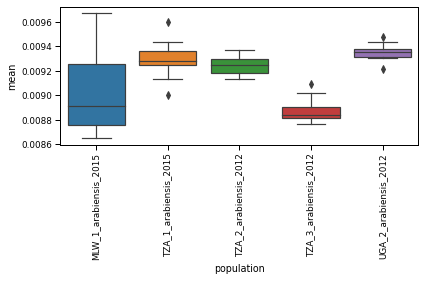

In [6]:
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci_10[df_loci_10.species == 'arabiensis'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("WattTheta_ss10_arabiensis.pdf")

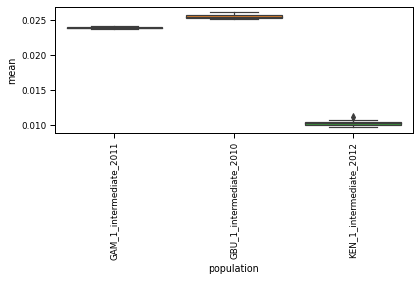

In [7]:
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci_10[df_loci_10.species == 'intermediate'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("WattTheta_ss10_intermediate.pdf")

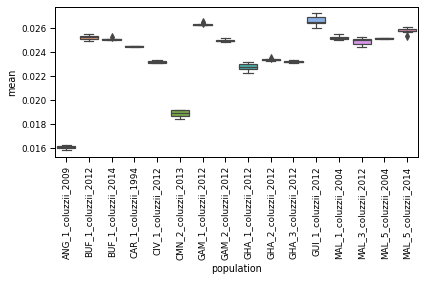

In [8]:
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci_10[df_loci_10.species == 'coluzzii'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("WattTheta_ss10_coluzzii.pdf")

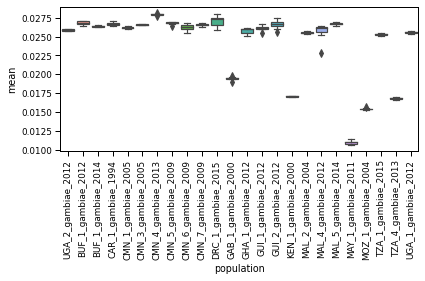

In [9]:
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci_10[df_loci_10.species == 'gambiae'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("WattTheta_ss10_gambiae.pdf")

In [ ]:
sample_size = 30
frac_loci = 0.01

In [ ]:
population = 'ANG_1_coluzzii_2009'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'BUF_1_coluzzii_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'BUF_1_coluzzii_2014'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'BUF_1_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'BUF_1_gambiae_2014'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [ ]:
population = 'CAR_1_gambiae_1994'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

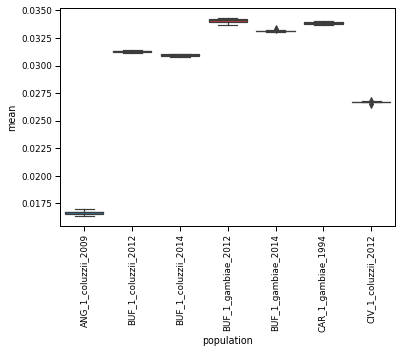

distributed.scheduler - INFO - Remove worker tcp://10.33.230.2:35147
distributed.core - INFO - Removing comms to tcp://10.33.230.2:35147


In [ ]:
population = 'CIV_1_coluzzii_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

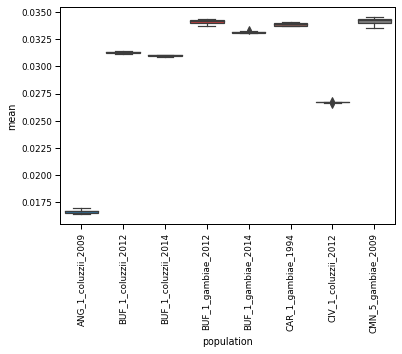

In [50]:
population = 'CMN_5_gambiae_2009'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

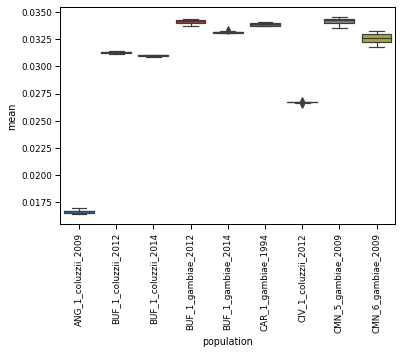

In [53]:
population = 'CMN_6_gambiae_2009'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

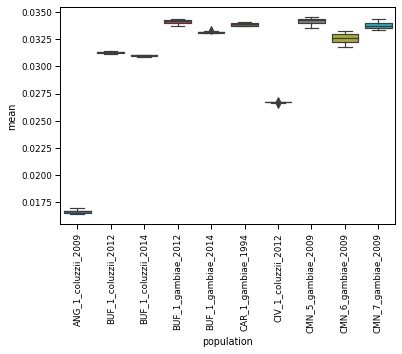

In [54]:
population = 'CMN_7_gambiae_2009'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

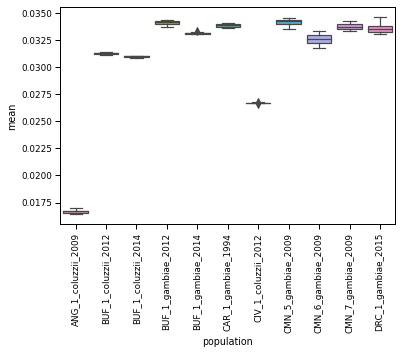

distributed.scheduler - INFO - Remove worker tcp://10.33.236.2:33497
distributed.core - INFO - Removing comms to tcp://10.33.236.2:33497
distributed.scheduler - INFO - Remove worker tcp://10.33.232.2:33925
distributed.core - INFO - Removing comms to tcp://10.33.232.2:33925
distributed.scheduler - INFO - Remove worker tcp://10.33.213.3:33589
distributed.core - INFO - Removing comms to tcp://10.33.213.3:33589
distributed.scheduler - INFO - Remove worker tcp://10.33.235.2:38565
distributed.core - INFO - Removing comms to tcp://10.33.235.2:38565
distributed.scheduler - INFO - Remove worker tcp://10.33.240.2:32787
distributed.core - INFO - Removing comms to tcp://10.33.240.2:32787
distributed.scheduler - INFO - Remove worker tcp://10.33.225.2:45363
distributed.core - INFO - Removing comms to tcp://10.33.225.2:45363
distributed.scheduler - INFO - Remove worker tcp://10.33.237.2:40849
distributed.core - INFO - Removing comms to tcp://10.33.237.2:40849
distributed.scheduler - INFO - Remove wor

In [55]:
population = 'DRC_1_gambiae_2015'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

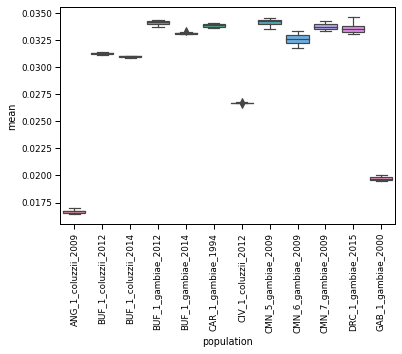

In [56]:
population = 'GAB_1_gambiae_2000'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

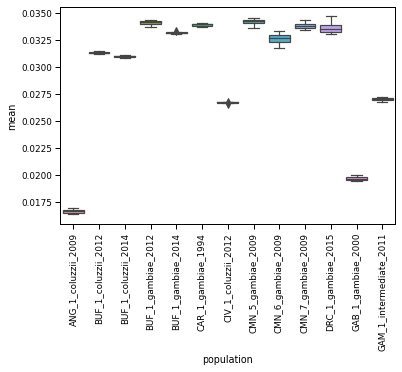

In [57]:
population = 'GAM_1_intermediate_2011'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

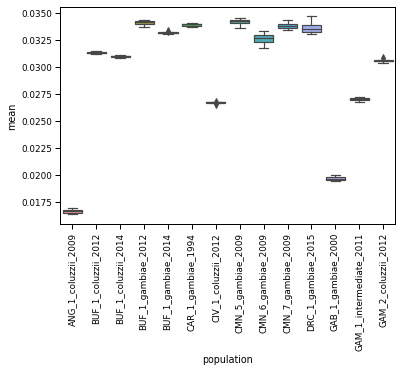

In [58]:
population = 'GAM_2_coluzzii_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

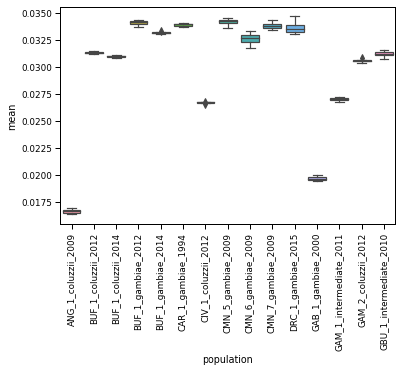

In [59]:
population = 'GBU_1_intermediate_2010'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

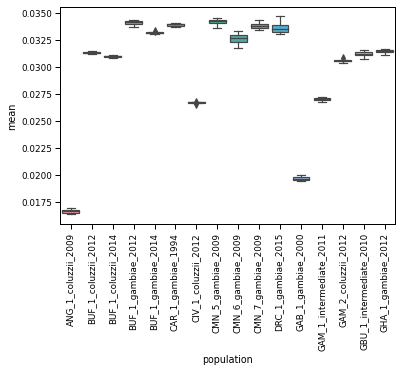

In [60]:
population = 'GHA_1_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

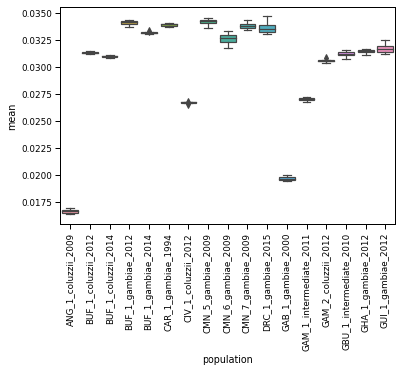

In [61]:
population = 'GUI_1_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

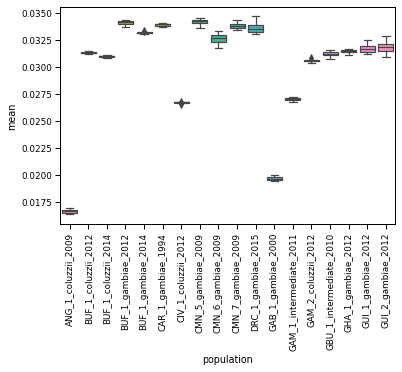

In [62]:
population = 'GUI_2_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

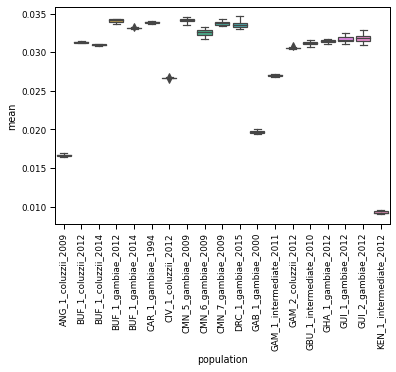

In [63]:
population = 'KEN_1_intermediate_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

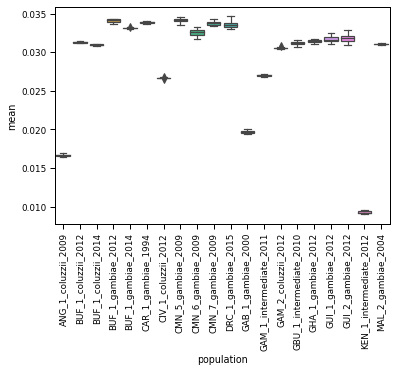

In [64]:
population = 'MAL_2_gambiae_2004'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

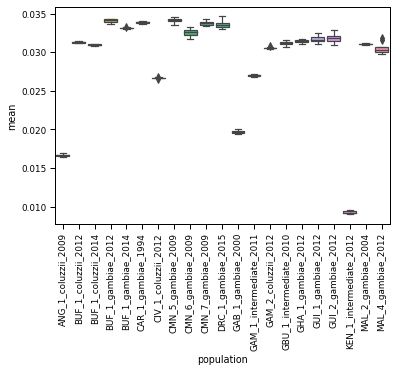

In [65]:
population = 'MAL_4_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

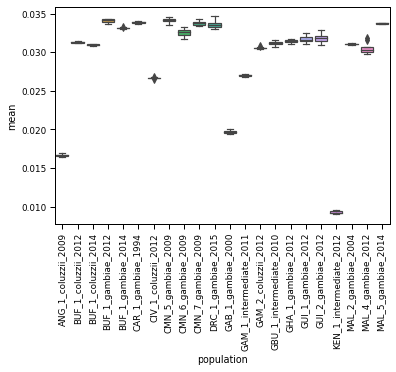

In [66]:
population = 'MAL_5_gambiae_2014'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

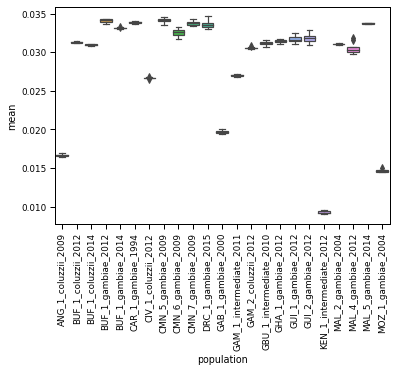

In [67]:
population = 'MOZ_1_gambiae_2004'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

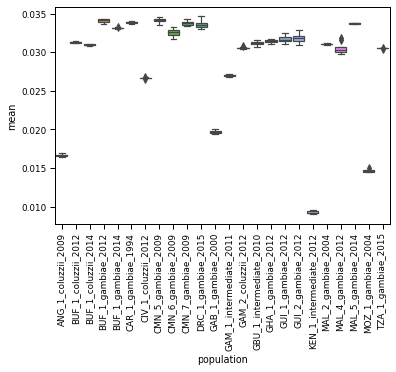

In [68]:
population = 'TZA_1_gambiae_2015'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

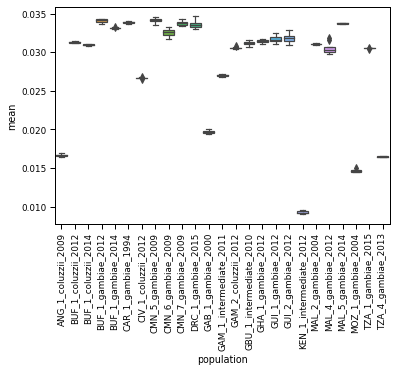

In [69]:
population = 'TZA_4_gambiae_2013'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

distributed.utils_perf - INFO - full garbage collection released 536.86 MB from 796 reference cycles (threshold: 10.00 MB)


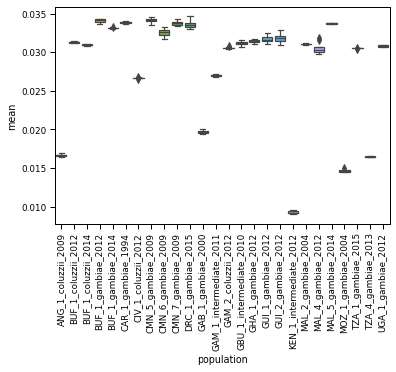

In [70]:
population = 'UGA_1_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

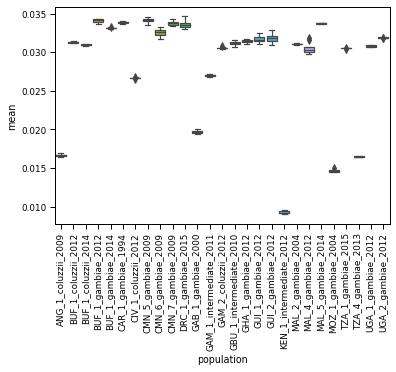

In [71]:
population = 'UGA_2_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

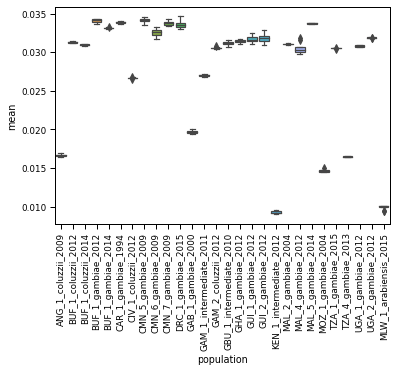

In [72]:
population = 'MLW_1_arabiensis_2015'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

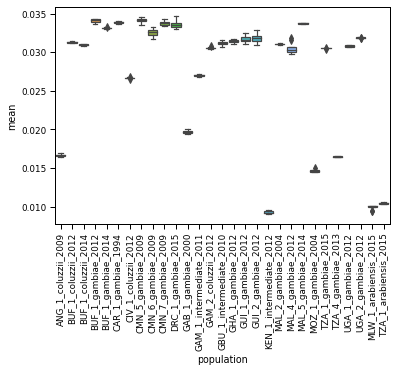

In [73]:
population = 'TZA_1_arabiensis_2015'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

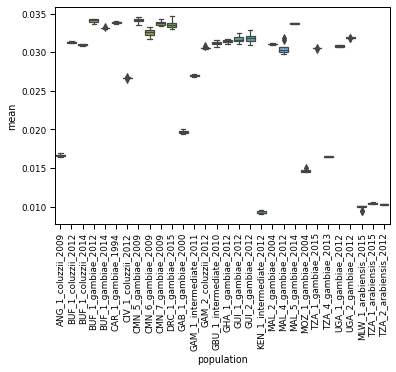

In [74]:
population = 'TZA_2_arabiensis_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

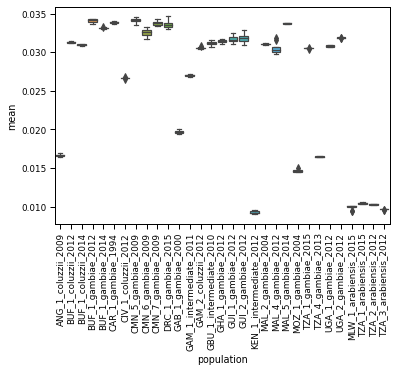

In [75]:
population = 'TZA_3_arabiensis_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

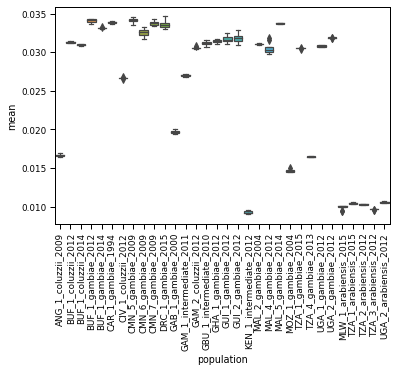

In [76]:
population = 'UGA_2_arabiensis_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 30])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [10]:
df_loci_30 = df_loci[df_loci.sample_size == 30]

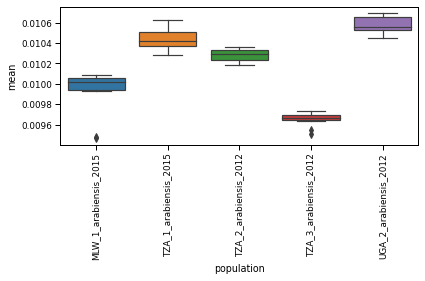

In [11]:
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci_30[df_loci_30.species == 'arabiensis'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("WattTheta_ss30_arabiensis.pdf")

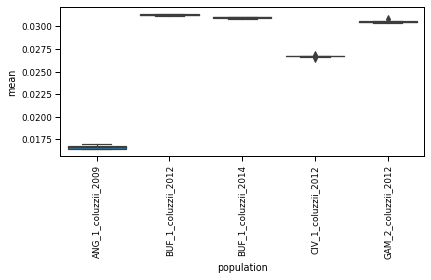

In [12]:
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci_30[df_loci_30.species == 'coluzzii'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("WattTheta_ss30_coluzzii.pdf")

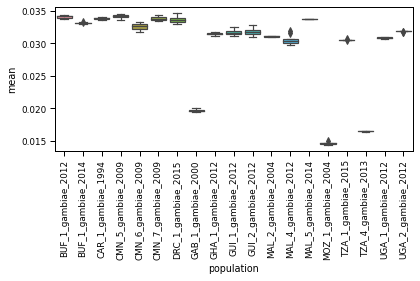

In [13]:
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci_30[df_loci_30.species == 'gambiae'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("WattTheta_ss30_gambiae.pdf")

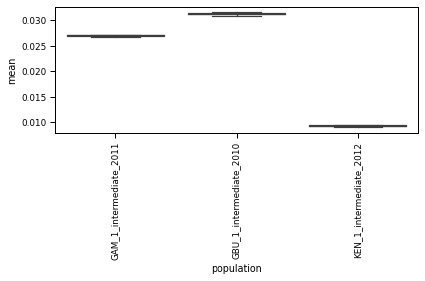

In [14]:
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci_30[df_loci_30.species == 'intermediate'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("WattTheta_ss30_intermediate.pdf")

In [89]:
sample_size = 70
frac_loci = 0.01

distributed.utils_perf - INFO - full garbage collection released 308.67 MB from 5677 reference cycles (threshold: 10.00 MB)


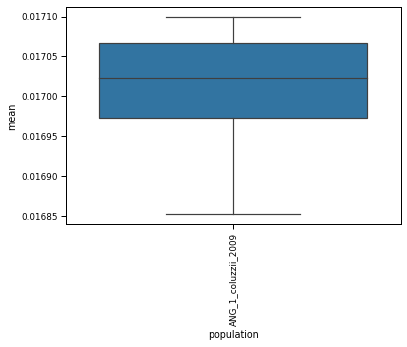

In [90]:
population = 'ANG_1_coluzzii_2009'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 70])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

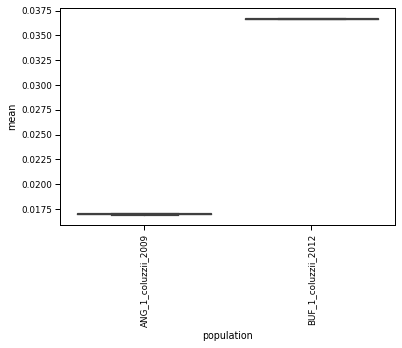

In [91]:
population = 'BUF_1_coluzzii_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 70])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

3L: 320824 320823


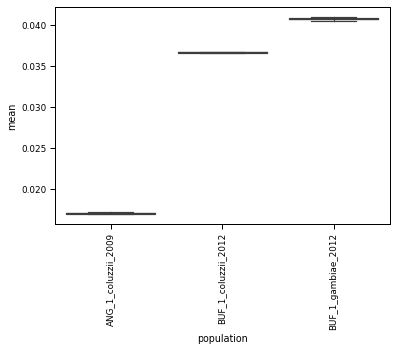

In [95]:
population = 'BUF_1_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 70])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

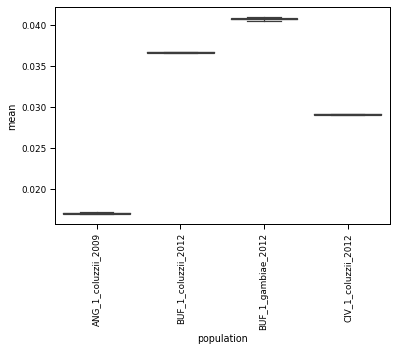

In [96]:
population = 'CIV_1_coluzzii_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 70])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

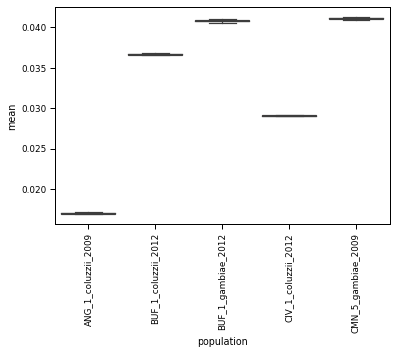

In [97]:
population = 'CMN_5_gambiae_2009'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 70])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

3R: 452957 452956


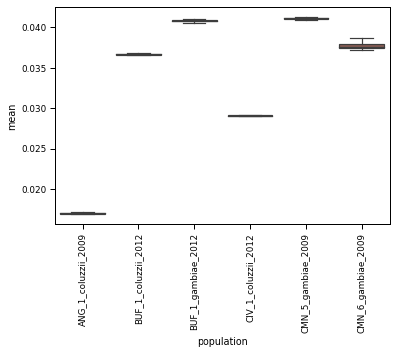

In [98]:
population = 'CMN_6_gambiae_2009'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 70])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

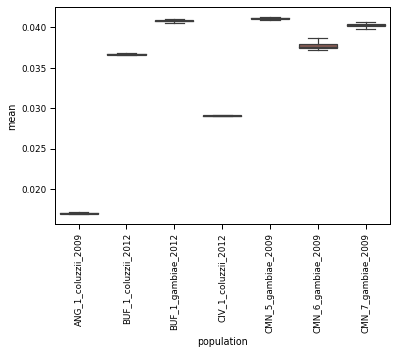

In [99]:
population = 'CMN_7_gambiae_2009'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 70])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

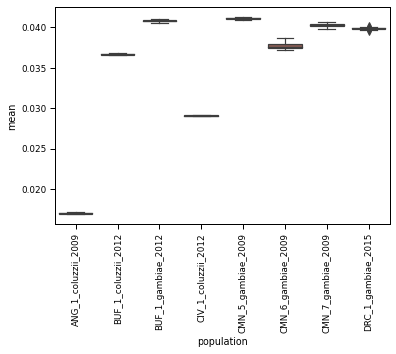

In [100]:
population = 'DRC_1_gambiae_2015'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 70])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

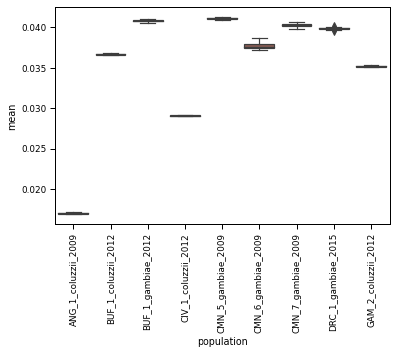

In [101]:
population = 'GAM_2_coluzzii_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 70])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

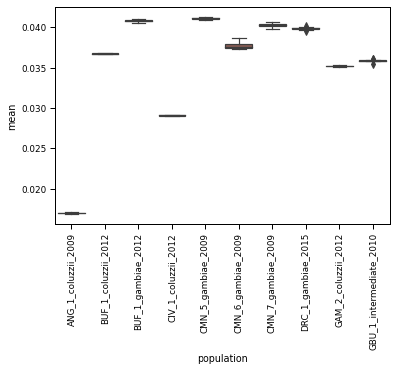

In [102]:
population = 'GBU_1_intermediate_2010'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 70])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

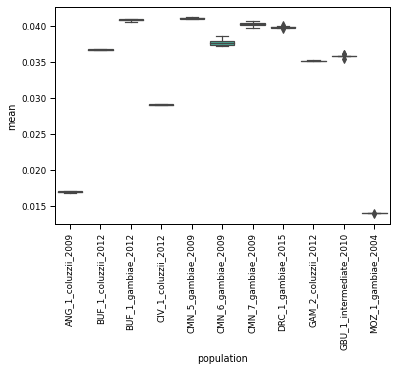

In [103]:
population = 'MOZ_1_gambiae_2004'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 70])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

distributed.utils_perf - INFO - full garbage collection released 536.88 MB from 282 reference cycles (threshold: 10.00 MB)


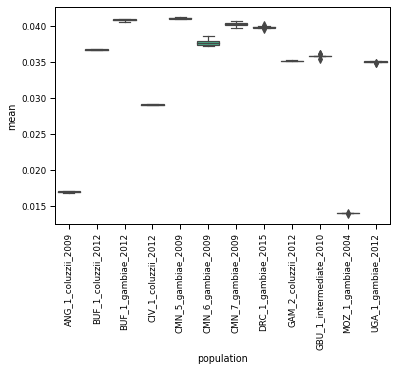

In [104]:
population = 'UGA_1_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 70])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

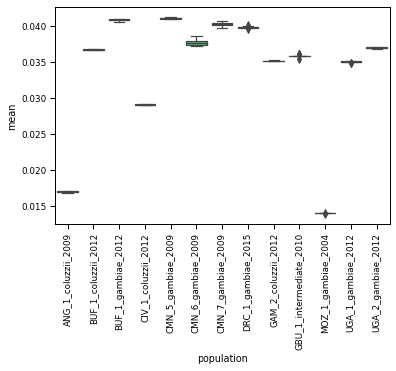

In [105]:
population = 'UGA_2_gambiae_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 70])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

distributed.utils_perf - INFO - full garbage collection released 280.51 MB from 12546 reference cycles (threshold: 10.00 MB)


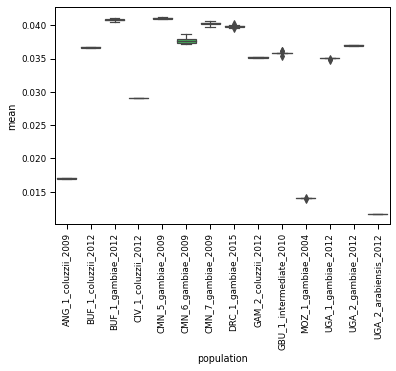

In [112]:
population = 'UGA_2_arabiensis_2012'
country, pop_n, species, year = population.split('_')
wat_list, m_w = plot_wat_pop_test(population, n_it = 10, sample_size = sample_size, frac_loci=frac_loci)
df_loci = df_loci.append(pd.DataFrame(data={'mean': [np.mean(wat) for wat in wat_list],
                            'population': [population] * len(wat_list),
                            'country': [country] * len(wat_list),
                            'pop_n': [pop_n] * len(wat_list),
                            'species': [species] * len(wat_list),
                            'year': [year] * len(wat_list),
                            'sample_size': [sample_size] * len(wat_list),
                            'frac_loci': [frac_loci] * len(wat_list)}))
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci[df_loci.sample_size == 70])
plt.xticks(rotation=90)
df_loci.to_csv('Watt-Theta-loci.csv',index=False)

In [15]:
df_loci_70 = df_loci[df_loci.sample_size == 70]
df_loci_70_select = df_loci_70[df_loci_70.population.isin(['BUF_1_coluzzii_2012', 'BUF_1_gambiae_2012', 'CMN_5_gambiae_2009', 'CMN_6_gambiae_2009', 'CMN_7_gambiae_2009', 'DRC_1_gambiae_2015', 'GAM_2_coluzzii_2012', 'GBU_1_intermediate_2010', 'UGA_1_gambiae_2012', 'UGA_2_gambiae_2012'])]

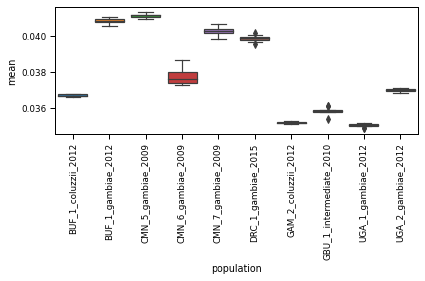

In [16]:
sns.boxplot(x = 'population', y = 'mean',
    data=df_loci_70_select)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("WattTheta_ss70.pdf")

<AxesSubplot:xlabel='dps', ylabel='mean'>

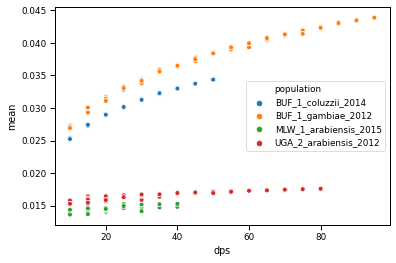

In [111]:
df_all = pd.read_csv('Watt-Theta.csv')
df_select = df_all[df_all.population.isin(['BUF_1_coluzzii_2014', 'BUF_1_gambiae_2012', 'MLW_1_arabiensis_2015', 'UGA_2_arabiensis_2012'])]
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_select)